Convert a IMOD NetCDF output result to the Ugrid NetCDF format that can be used by D-Eco Impact

In [1]:
#load required libraries and prepare logging
import os
import xugrid as xu
import xarray as xr
import geopandas as gpd
import numpy as np
import rioxarray
import xarray
import logging
import imod

logger = logging.getLogger(__name__)

import sys  
sys.path.insert(1, '../library')
from DEcoImpact_conv_func import DEIModel

In [2]:
#configuration
os.chdir(r"p:\11210262-001-stakeholders-tools\Virtual_Climate_Lab\Maaike\decoimpact")

## PARAMETERS
modelname = 'referentie_2021_reduced'

#configuration
ds_in = r'p:\11207941-005-terschelling-model\terschelling-gw-model\data\VCLtijdelijk\to_share\head_Hd_2021.nc' #input location of file that needs to be converted
area = rioxarray.open_rasterio(r'p:\11210262-001-stakeholders-tools\Virtual_Climate_Lab\01_data\dataset\originele_bodem.tif')  #raster file of area

#Where to write the D-Eco impact input file
ds_out = "DEI_IMOD_output_"+ modelname + ".nc"   #output location of file that can be loaded by D-Eco Impact
crs_code = "epsg:28992"                          #coordinate system applicable to file

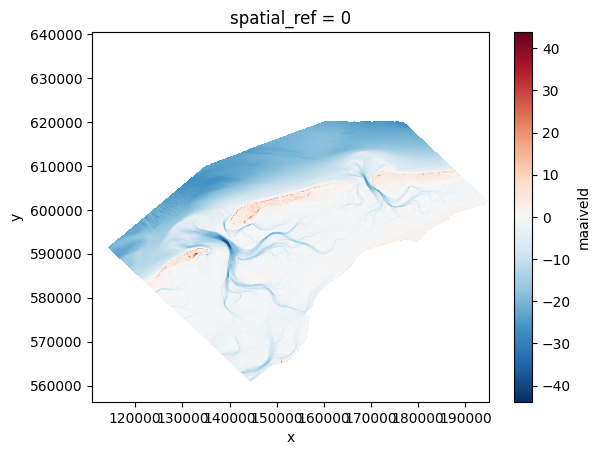

In [3]:
#maaiveld voorbereiding
maaiveld_da = area.isel(band = 0)
maaiveld_da = maaiveld_da.drop("band")
maaiveld_da = maaiveld_da.rename("maaiveld")
maaiveld_ds = maaiveld_da.to_dataset()
maaiveld_ds_fv = maaiveld_ds.where(maaiveld_ds['maaiveld'] != -9999.)  
maaiveld_ds_fv["maaiveld"].plot.imshow()

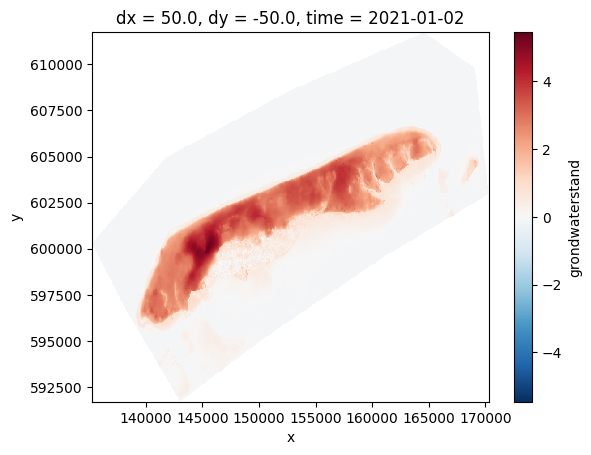

In [4]:
#Calculate upper freatic groundwater level
# Credits : Janneke Pouwels, Huite Bootsma
# links : https://deltares.github.io/imod-python/_modules/imod/select/layers.html#upper_active_layer
# p drive: p:\11207941-005-terschelling-model\Archive\2023-06-22 Aanleveren data\VoorMaaike_sept23\Aanleveren ugrid_v3.py

## Freatische grondwaterstand berekenen
with xr.open_dataset(ds_in, chunks={"time": 1}) as heads:
    heads_layer = heads.swap_dims({"z": "layer"})
    upper_active_layer = imod.select.upper_active_layer(heads_layer["head"].isel(time=0), is_ibound=False)
    
    heads_freatic = heads_layer.where(heads_layer.layer == upper_active_layer)

    #select layer value without nan values
    heads_freatic = heads_freatic.min("layer")

dataset = xr.Dataset()
dataset['grondwaterstand'] = heads_freatic["head"]

#present the data
dataset['grondwaterstand'].isel(time=0).plot.imshow()


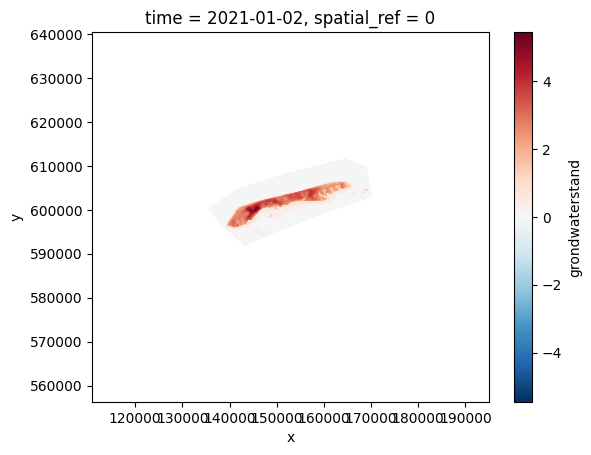

In [5]:
#regird the data based on the bathymetry
multilin_regridder = imod.prepare.Regridder(method = "multilinear", ) # prepare
da_regridded = multilin_regridder.regrid(dataset['grondwaterstand'], maaiveld_ds_fv["maaiveld"])
da_regridded = da_regridded.rename("grondwaterstand")
da_regridded.isel(time =0).plot.imshow()   

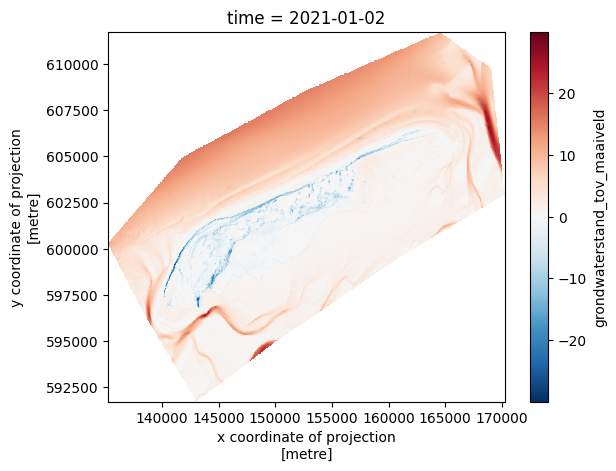

In [6]:
#make dataset grondwaterstand and maaiveld
dataset_combined = xr.merge([da_regridded, maaiveld_ds_fv], compat="identical")
dataset_combined["grondwaterstand_tov_maaiveld"] = dataset_combined["grondwaterstand"] - dataset_combined["maaiveld"]

#clip the dataset by a bounding box of the model
min_x = dataset.x.min().item() ; max_x = dataset.x.max().item()
min_y = dataset.y.min().item() ; max_y = dataset.y.max().item()

dataset_combined_mdim = dataset_combined.rio.clip_box(min_x,min_y,max_x,max_y)
dataset_combined_mdim = dataset_combined_mdim.drop("spatial_ref")

# show result
dataset_combined_mdim["grondwaterstand_tov_maaiveld"].isel(time=0).plot.imshow()

In [7]:
#verwijder de orginele grondwaterstand
dataset_combined_mdim = dataset_combined_mdim.drop("grondwaterstand") 

## Tussentijds opslaan
temp_output_name = f'example_output_data/Grondwaterstand_tov_mv_{modelname}.nc'
dataset_combined_mdim.to_netcdf(temp_output_name)

In [8]:
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)

#read Netcdf
region_dict = {"imod": temp_output_name}
DEI.setup_ugrid(region = region_dict, crs = crs_code)
DEI._mesh2d = DEI._mesh2d.dropna(dim = "mesh2d_nFaces", how = 'all')
DEI._mesh2d["time"] = DEI._mesh2d["time"].assign_attrs({"_FillValue": False})
print(DEI._mesh2d)


#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file_.nc", fn_ecoimpact = "example_output_data/" + ds_out)

print("Done.")

<xarray.Dataset> Size: 5GB
Dimensions:                       (mesh2d_nNodes: 1747926,
                                   mesh2d_nFaces: 1745151, time: 364,
                                   mesh2d_nEdges: 3493076)
Coordinates:
    mesh2d_node_x                 (mesh2d_nNodes) float64 14MB 1.391e+05 ... ...
    mesh2d_node_y                 (mesh2d_nNodes) float64 14MB 6.117e+05 ... ...
  * time                          (time) datetime64[ns] 3kB 2021-01-02 ... 20...
    mesh2d_edge_x                 (mesh2d_nEdges) float64 28MB 1.391e+05 ... ...
    mesh2d_edge_y                 (mesh2d_nEdges) float64 28MB 6.117e+05 ... ...
    mesh2d_face_x                 (mesh2d_nFaces) float64 14MB 1.391e+05 ... ...
    mesh2d_face_y                 (mesh2d_nFaces) float64 14MB 6.117e+05 ... ...
  * mesh2d_nNodes                 (mesh2d_nNodes) int64 14MB 0 1 ... 1747925
  * mesh2d_nFaces                 (mesh2d_nFaces) int64 14MB 0 1 ... 1745150
  * mesh2d_nEdges                 (mesh2d_nEdges) i

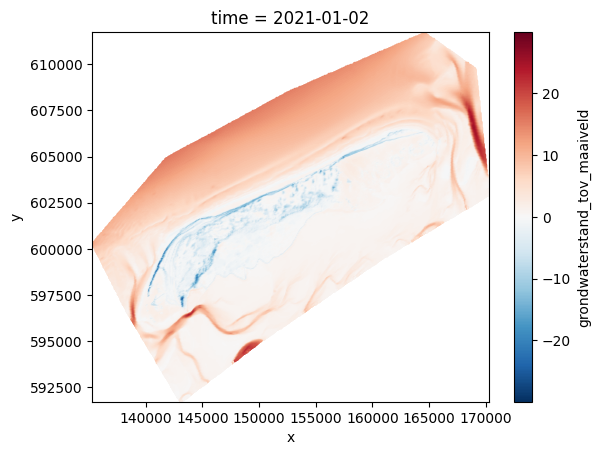

In [9]:
#visualize results
with xu.open_mfdataset("example_output_data/"+ds_out) as result:
    result["grondwaterstand_tov_maaiveld"].isel(time= 0).ugrid.plot()